# Test of GraphSAGE
- the version of the 80 repeat times
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:0


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [5]:
datasets = ['repeat_train_80', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/repeat_train_80.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [17]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(32)

- Turn the print message to a log file

In [7]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1010_22:15_GraphSAGE_transR_50.log


### Model

In [8]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'pool')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
        h = self.layer2(g, h)
        return h

In [9]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [10]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [11]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 5000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [12]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [13]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

- Check if model really load the model_dict

In [14]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

In [18]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = GraphSAGE(in_dim=50, hidden_dim=16, out_dim=167)
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
# in_dim means the dimension of the node_feat(50 dim, since the 50-dim embedding)
# out_dim means the # of the categories -> 168 for out tasks
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-5.pt"

model = model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 50

# save the best model
best_val_loss = float('inf')
patience = 10  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.


# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0
    
    for batched_g in tqdm(dataloaders['repeat_train_80'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
            
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

#         print(best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            add_log_msg("============================== Early stopping ==================================")
            break

  0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/10/2023, 22:19:42# labels of 5000: tensor([ 34,  18,  44, 112,   4, 111, 144,   9,   9,  48,  67,  67,  67,  67,
         67,  33,  97, 152,  54,  57,  31, 152,  44,  38,  83,  97,  87, 143,
        121,  49,  18,  92, 109, 121, 111,  97], device='cuda:0') torch.Size([36])
10/10/2023, 22:19:42# predicted of 5000: tensor([121,  57, 121,  36, 121,  36, 121,  36,  36,   9,   9,   3,   3,   3,
          3, 121,  36,  57,  57, 121,  57,  36, 121,  36, 121, 121, 121, 121,
         57, 121, 121, 121, 121, 121, 121, 121], device='cuda:0') torch.Size([36])
10/10/2023, 22:21:10# labels of 10000: tensor([158, 111,  97, 124,  54, 163,  48, 164, 164,  14, 150,  24, 104, 143,
         53, 151,  55,  18,  34, 162,  74, 122, 122, 122, 122, 122, 122, 122,
         36, 119,  74,  11,  54,   9,  74, 109, 119, 116], device='cuda:0') torch.Size([38])
10/10/2023, 22:21:10# predicted of 10000: tensor([ 31, 158,  31, 158,  31,  31,  31,  31,  31,   4,  31,  31,  31, 158,
         18,  31,  31,  31,  31,  3

10/10/2023, 22:35:43# labels of 60000: tensor([163,   1, 144,  83, 150,  14, 111, 124, 111,  33,  11,  60,  49, 143,
        109, 163,  53, 158,  74,   4,  87, 116, 151,  55,  42,  55,  11, 162,
        158, 157,  35,  35,  35,  35,  35,  35,  55], device='cuda:0') torch.Size([37])
10/10/2023, 22:35:43# predicted of 60000: tensor([ 92,  42,  57,  47,  14,  12, 124, 162,   1, 121,  83,  11, 150,  11,
         12, 150,  47, 124, 163,  42,  18,   1,  87,  11, 143,  34, 158, 158,
        158,  12,  35,  35,  35,  35,  35,  35,  92], device='cuda:0') torch.Size([37])
10/10/2023, 22:37:11# labels of 65000: tensor([ 36, 164,  13,  13,  13,  13,  13,  44,  83, 124, 164,  57,  83, 152,
        142,  49, 152,  83, 124, 125, 158,  42, 158,  76,  31,  53,  31, 144,
         60,  60,   9,  65,  46,  46, 151,   1, 125,  24], device='cuda:0') torch.Size([38])
10/10/2023, 22:37:11# predicted of 65000: tensor([158,   2,  13,  13,  13,  13,  13,  14,   2,  92,  53,  92,  83, 104,
          2,  49, 157, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/10/2023, 22:49:56# labels of Validation: tensor([ 34,   5,   5,   5,  53,  71,  71,  71,  71,  71,  71, 129, 129, 129,
        129, 129, 129, 129,  80,  80,  80,  80,  80,  80,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16, 121, 125, 126, 126, 126,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 22:50:06# Validation Loss: 0.2187 | Validation Accuracy: 0.9509



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/10/2023, 22:51:35# labels of 5000: tensor([104,  55,  18,  53, 152,   9, 121,  42,  76, 162, 112,  39,  39,  39,
         59,  59,  59, 142,   1,  60,  18, 121, 157, 109,  55, 158, 124,  38,
         74,  74,  36,  57,   4,  54,  14, 163], device='cuda:0') torch.Size([36])
10/10/2023, 22:51:35# predicted of 5000: tensor([ 14, 142,  48,  47,  49,  83,  31,  87,  92,  81, 104,  39,  39,  39,
         38,  38,  38, 164, 164, 119,   9,  31,  12, 142, 121, 158,  83,  74,
         14, 142,  60, 143,   9, 142,  92,  76], device='cuda:0') torch.Size([36])
10/10/2023, 22:53:03# labels of 10000: tensor([ 34,  83,  57,  87,   4,  87, 112,  14,  48, 144,  53, 150,  18,   1,
        152,  87,  76, 142,  18, 144,  48, 108, 108, 108, 108,  74,  54,  12,
         74,  18,   2,  83,  48, 116, 121], device='cuda:0') torch.Size([35])
10/10/2023, 22:53:03# predicted of 10000: tensor([ 34, 119, 119,  34,  44,   1,  74, 151, 142,  87,  33, 162, 124, 151,
         55,   4,  34, 157, 104,  12,  33, 131, 13

10/10/2023, 23:12:49# labels of 75000: tensor([ 60,  36, 150,  33,  30,  47,  49,  87,  54, 150,  60,  31,  53, 162,
         31,  11, 143,  81, 125,  36,  83,  55, 144, 104,  87,  42,   1,  11,
        111,  74, 119,  24], device='cuda:0') torch.Size([32])
10/10/2023, 23:12:49# predicted of 75000: tensor([ 60,  38, 112,  55,  97, 124,  38, 116, 116,  48,  34, 150,  53, 152,
        150, 163, 112,  34,  74,   9,  30,  53,  11,   4, 124,  53, 164,  11,
         12,   4,  81,  11], device='cuda:0') torch.Size([32])
10/10/2023, 23:14:17# labels of 80000: tensor([ 47, 125, 116,  97,  92,  24, 116,  11,  14,  14,  10,  10, 152, 164,
         47, 157,  33,  42, 163,  60, 143,  42,  34,  87,  76,  48, 112, 142,
          2, 112,  80,  80,  80,  80,  80,  80, 157, 109], device='cuda:0') torch.Size([38])
10/10/2023, 23:14:17# predicted of 80000: tensor([ 92,  92,  87,  53,  76, 112,  49, 104,  97,  53,  10,  10,  31, 163,
         92,  14,  81,  87,  92,  33,  53,  60, 163,  30,  76, 162,  30, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/10/2023, 23:22:55# labels of Validation: tensor([ 21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  18,  75,  67,
         67,  67,  67,  67, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132, 132,
        132, 132, 13

10/10/2023, 23:23:05# Validation Loss: 0.2221 | Validation Accuracy: 0.9511



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/10/2023, 23:24:35# labels of 5000: tensor([ 12,  36, 162, 143, 139, 139, 139, 139, 139, 157, 125,  49,  81,  33,
         11, 163,  92,  34,  92,  76, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 112,  36, 130, 130, 130, 130, 130,
        112, 150, 124, 124,   1,  54,  42,  92, 109,  55, 151, 112],
       device='cuda:0') torch.Size([54])
10/10/2023, 23:24:35# predicted of 5000: tensor([ 24,  92,   1, 143, 139, 139, 139, 139, 139,  48,  81,  76, 151,  87,
        152,  30,  92, 119,  24, 116, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 143,  55, 130, 130, 130, 130, 130,
          2,  81,  87,  36,  75, 162,  53,  11,  34,  38,  53, 112],
       device='cuda:0') torch.Size([54])
10/10/2023, 23:26:04# labels of 10000: tensor([119, 125,  54,  83, 150, 157,  11, 116, 158,  11, 112, 125,   2,  97,
        104,  83, 152,   9, 150,  42,  18, 119,  57,  97,  14, 111, 150,  57,
        143, 142,  60,  76], device='c

10/10/2023, 23:40:44# labels of 60000: tensor([  4,   2,   4,  36,  24,  36, 112, 144, 157,  75,  48, 109, 116, 157,
         97,  30,  87,  55,  30, 163, 125,  44,  18,  36,  31,  97,  81,  11,
         53,  36,  35,  35,  35,  35,  35,  35,  97], device='cuda:0') torch.Size([37])
10/10/2023, 23:40:44# predicted of 60000: tensor([121, 151,  30,   4,  14,  53,  53, 124,  34,  24,  92,  97,  76,  81,
         53, 157, 143,  55,  18,  36,  47,  54,  74,  81,  97,  87, 158,  53,
        119,   9,  35,  35,  35,  35,  35,  35,   4], device='cuda:0') torch.Size([37])
10/10/2023, 23:42:10# labels of 65000: tensor([ 36,  81,  24,  75,  74, 157,  34, 119,  87,   2,  83,  36,   1,   9,
        111,   4, 112, 125,  30,  47, 109, 142, 152, 164,  59,  59,  59,  54,
        125,  14, 163,  74,  54, 125], device='cuda:0') torch.Size([34])
10/10/2023, 23:42:10# predicted of 65000: tensor([ 53, 163,  60, 119,   9,  33, 124, 119, 150,  81,  83, 150,  92,   9,
         38,  47,  34,  12,  76, 158, 150, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/10/2023, 23:55:33# labels of Validation: tensor([146, 146, 146,  ...,  80,  14,   4], device='cuda:0') torch.Size([2096])
10/10/2023, 23:55:33# predicted of Validation: tensor([146, 146, 146,  ...,  80,  75,  76], device='cuda:0') torch.Size([2096])
10/10/2023, 23:55:33# labels of 0: tensor([146, 146, 146,  ...,  80,  14,   4], device='cuda:0') torch.Size([2096])
10/10/2023, 23:55:33# predicted of 0: tensor([146, 146, 146,  ...,  80,  75,  76], device='cuda:0') torch.Size([2096])
10/10/2023, 23:55:44# Validation Loss: 0.2390 | Validation Accuracy: 0.9497



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/10/2023, 23:57:13# labels of 5000: tensor([ 49,  74, 163, 151,  87,  14, 163, 158, 116, 109,  60,  81, 111,  75,
         47,  74,  76, 107, 107, 107, 107, 107, 107, 107, 107, 163, 142,  11,
        121, 104, 162, 125,   4, 125,  81,  87, 125,  55,   2],
       device='cuda:0') torch.Size([39])
10/10/2023, 23:57:13# predicted of 5000: tensor([131,  49,  92, 119,  48, 119,  87,  92, 104, 112,  49, 109,  81, 163,
         53,  97,  81, 107, 107, 107, 107, 107, 107, 107, 107, 163, 162, 163,
         83,  12,  87, 125, 142, 152,  12, 104,  12,  49,  38],
       device='cuda:0') torch.Size([39])
10/10/2023, 23:58:43# labels of 10000: tensor([112, 158,  97, 104,  92,  60,  11, 121,   2, 143,   1,  83,  57, 144,
         87,  49,  33,  47, 157, 143, 104,  30,  44,  33, 151, 114, 114, 157,
        152,  12, 152, 150, 143], device='cuda:0') torch.Size([33])
10/10/2023, 23:58:43# predicted of 10000: tensor([119,  55,  57,  30,  92,  18,  11,  81,  42, 164,  48, 109,  34, 111,
         97,  36

10/11/2023, 00:19:59# labels of 70000: tensor([143,  36, 125,   9, 124,  47, 164, 142, 119, 111, 121, 143,  30,   4,
        121,   4,  60, 164,  74,  83,  38, 119, 121, 163,   9, 150,   9,  97,
          9, 144, 116, 119], device='cuda:0') torch.Size([32])
10/11/2023, 00:19:59# predicted of 70000: tensor([ 14,  34, 150,  57,  14,  74, 116,  57,  34,  97, 158,  97,  47,  31,
        121,  60,  57,  30,  57,  97,  57, 150, 142, 164,  57, 142, 158,  83,
         97,  14, 116, 111], device='cuda:0') torch.Size([32])
10/11/2023, 00:21:49# labels of 75000: tensor([ 55, 116, 119,  36,  55, 104,   2, 121,  75,  42, 164, 119, 125, 143,
         47,  54,  18,  92,  42,  36,   2, 112, 143, 112,  18,  38, 142,  97,
         53, 142, 112,  53], device='cuda:0') torch.Size([32])
10/11/2023, 00:21:49# predicted of 75000: tensor([ 81, 150, 143, 124, 119,   9,  75,  60,  24, 158,   4,  87,  92,   1,
        152, 142,  97, 125, 144,  92,  81,  47,  87,   1,  75,  60,  60,  97,
        163, 151,   9,  5

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 00:33:56# labels of Validation: tensor([ 60,  55, 100, 100, 100, 100, 100, 100,  73,  73,  73, 147,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65, 147, 147, 147, 147,
         28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,  90,
         90,  69,  69,  69,  69,  69,  69, 104,  60, 130, 130, 130, 130, 130,
         86,  86,  35,  35,  35,  35,  35,  35,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 00:35:48# labels of 5000: tensor([ 57, 111, 151, 111,  38,  53,  44,  60,  60,  14, 157,  11,   2, 158,
         11, 125, 104, 151, 162,   2, 112, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 116,
          9,   1,  74,  44,  48,  81,  60, 143,  47], device='cuda:0') torch.Size([51])
10/11/2023, 00:35:48# predicted of 5000: tensor([ 24,  33,   1,  74, 157,  54,  92,   9, 121, 152,  47, 109,  92,  14,
        164,   1,  30, 151, 162, 112,  53, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,  92,
         12, 144,  92,  12, 124, 125, 124,  97,  72], device='cuda:0') torch.Size([51])
10/11/2023, 00:37:19# labels of 10000: tensor([ 42, 104,  87,  57, 164,  83,  48,  12, 162, 139, 139, 139, 139, 139,
        116,  42, 119,  31,  53, 157,  55,  48, 124,  24,  53,  31, 157, 121,
         44, 125,  76, 109, 109,  83,  92,  76], device='cuda:0') torch.Size([36])

10/11/2023, 00:57:26# labels of 75000: tensor([  9,  83, 151,  74, 112,  49,  36,  30, 124,  31, 112,  44, 163, 164,
        164, 151,  53,  83,  12,  48, 111, 111,  74,  81, 150, 151, 109,  74,
        157,  87,  81,  83], device='cuda:0') torch.Size([32])
10/11/2023, 00:57:26# predicted of 75000: tensor([ 55, 119, 125,  24,   4,  24,  36,  30,  57, 163,  14,  81,  97,  53,
        157,  97, 124,   2,  11,  53,  83,  76,  97,  24, 152,  31, 116,  92,
         47, 112,  81,  74], device='cuda:0') torch.Size([32])
10/11/2023, 00:58:53# labels of 80000: tensor([116,  74, 150,  14,  81, 112, 124,  33,  48,  24,  42,  60, 125,  76,
         83,  57,  97,  92,  97,   4,  74,   9,   9,  55,  87,  12,  36,   1,
        119,  44,  33, 142], device='cuda:0') torch.Size([32])
10/11/2023, 00:58:53# predicted of 80000: tensor([119,   1,  97, 142, 162,  24, 152,  74,  36,  97,  18,  53,  47,  76,
          4,   1,  97,  57, 162, 142,  76,  47,  11,  48, 124,  92,  30, 162,
         76, 164,  75,  3

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 01:07:33# labels of Validation: tensor([143,  18,  96,  96,  96,  96,  96,  96,  47,  14,  65,  65,  65,  65,
         65,  65,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70, 110, 110,   1,
          0,   0,   0,   0,   0,   0, 124,  64,  64, 130, 130, 130, 130, 130,
         65,  65,  65,  65,  65,  65, 141, 141, 141, 141, 141, 141, 141, 141,
        141, 141,  55, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 105,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,  21,   4,
        129, 129, 129, 129, 129, 129, 129,  43,  43,  26,  26,  26,  26,  26,
         26,  43,  43, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 01:07:47# Validation Loss: 0.2322 | Validation Accuracy: 0.9503



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 01:09:17# labels of 5000: tensor([ 57,  18, 163, 144,  57,  49, 116,  57, 163,  47, 157,  53,   2,  53,
         74,  48, 157,   2, 162,  57,   9, 164, 152, 111,  12,  97,   4, 111,
        144,  30,  44,  34], device='cuda:0') torch.Size([32])
10/11/2023, 01:09:17# predicted of 5000: tensor([109,  18,  30, 144,  81,  49,  53, 124,  97,  81, 144,  36, 142,  47,
          4,   1, 157, 163, 142,  34, 121, 152,  87, 119,  87,  97,  92, 142,
         81, 163, 116,  97], device='cuda:0') torch.Size([32])
10/11/2023, 01:10:46# labels of 10000: tensor([ 33,  57,  18,  97, 112,  60, 119,  75, 143,  12,  12,  34,  57, 164,
         42,  12,  57, 116,  49,   2,   1, 112, 160, 160, 160, 160, 160, 160,
        160, 160,  60,  12,  36, 109,  55,  33,   4,  11, 162],
       device='cuda:0') torch.Size([39])
10/11/2023, 01:10:46# predicted of 10000: tensor([158,  31, 152,  97, 111,  54,  83, 121,   2,  36,  42,  18, 121,  97,
         87,  83,  18, 116, 109, 109,  54,  48, 160, 160, 160, 

10/11/2023, 01:32:16# labels of 80000: tensor([ 76,   9, 104, 109, 152, 158,  92,  87, 104, 111, 125,  14,  75, 144,
        163,  88,  88, 109,   4,  37,  37,  37,  37,  37,  60, 164,  14, 109,
         97,  92,  48,  60,  11,  33,  48,  76,  60], device='cuda:0') torch.Size([37])
10/11/2023, 01:32:16# predicted of 80000: tensor([ 34,  12,  57,   1,   4, 116,  53, 124,  76,  34,   4, 162,  31,  34,
        157,  42,  42,  57,  76,  37,  37,  37,  37,  37, 124, 164, 121,  57,
        116,  33,  12,  81,  57,  30,  53,  76,  18], device='cuda:0') torch.Size([37])
10/11/2023, 01:33:45# labels of 85000: tensor([ 44,  75,   2,  30,  12,  47,  49,  18,  83,  11, 109,  24,   9, 111,
         92, 142,  34,  87,  57,  55, 151,  97, 162, 112,  33, 111,  31, 142,
         83,  76,  36, 119], device='cuda:0') torch.Size([32])
10/11/2023, 01:33:45# predicted of 85000: tensor([143,  92,   2, 163,  92, 116,  49,  34, 158, 119, 112,  74, 124,   4,
        152, 116,  47,  75, 151, 150,  12,  76, 125, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 01:40:46# labels of Validation: tensor([161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161,  61,  61,  61, 158,
        137, 137, 137, 137, 137,  28,  28,  28,  28,  28,  65,  28,  28,  28,
         28,  28,  2

10/11/2023, 01:40:57# Validation Loss: 0.2329 | Validation Accuracy: 0.9501



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 01:42:25# labels of 5000: tensor([125,  81, 164,  54, 104,  11,  74,  12,   6,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,  87,  14, 112,  11, 119,  47,  75,  31, 143,
        125,  94,  94, 151,  87, 157, 112,  81,  42, 150, 142,  42, 151, 112,
        164], device='cuda:0') torch.Size([99])
10/11/2023, 01:42:25# predicted of 5000: tensor([152,  81,  30, 152, 158, 124,  87,  53,   6,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,   

10/11/2023, 01:52:47# labels of 40000: tensor([ 74, 157,  83,  49,  24,  92,   1,  54,  49, 125,  48,  54,  87,   4,
        121, 104,  74,  24, 142,  34,   4, 143, 111,  66,  66,  66,  66,  66,
         66,  66,  66,  66,  66, 162,  48,  60,  92,  75, 152,  12,   9],
       device='cuda:0') torch.Size([41])
10/11/2023, 01:52:47# predicted of 40000: tensor([151,  14,  47,   1,  33,  48,  55, 121,  81,  47, 152, 109,  33, 152,
         24,  49, 143,  30,  34, 150, 150,   2,  11,  66,  66,  66,  66,  66,
         66,  66,  66,  66,  66,   4,  48,  74,  47,  75,  81,  92, 124],
       device='cuda:0') torch.Size([41])
10/11/2023, 01:54:15# labels of 45000: tensor([ 42,  92,  36,  55, 125,   9, 111,  34,   4, 143,  76,  47, 152,  55,
        124,   2, 113, 113,  83,  55, 111,  18,  54, 111,  24,  24,  83, 162,
         54,  97,  83,  30,  44], device='cuda:0') torch.Size([33])
10/11/2023, 01:54:15# predicted of 45000: tensor([158,  92, 163,  47,  34, 109, 111, 164, 152, 116,  24,  47,   1,

10/11/2023, 02:12:36# labels of 105000: tensor([ 42,  42,  97, 111, 104,  53,  12, 152,  92, 116,  75,  87,  30,  34,
          1,  47,  44,  54,  30, 144, 125,   2, 121,  92,  44,   9,  74, 109,
         63,  63,  63,  63, 116, 121, 124], device='cuda:0') torch.Size([35])
10/11/2023, 02:12:36# predicted of 105000: tensor([ 42, 109, 116,  12, 158,  53,  12, 158, 125, 151, 116, 142,  53, 119,
          1,  47, 121,  74,   9,  33,  76, 150, 121,  92,  83, 151, 162, 109,
         63,  63,  63,  63,  36,  34,  49], device='cuda:0') torch.Size([35])
10/11/2023, 02:13:41# total batches: 108800
10/11/2023, 02:13:41# Epoch 6 | Train Loss: 3.0411 | Train Accuracy: 0.2443


Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 02:13:41# labels of Validation: tensor([125,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  87,  50,  50,  50,   2,  27,  27,
         27,  91,  91,  91,   0,   0,   0,   0,   0,   0, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 110, 110,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,
         17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  17,  98,  45,  65,
         45,  45, 14

10/11/2023, 02:13:54# Validation Loss: 0.2314 | Validation Accuracy: 0.9504



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 02:15:25# labels of 5000: tensor([109, 162, 151, 163,  38,  54,  36,  76,  48, 151,  49, 158,  42, 143,
         36,  54,  55,  64,  64,  36,  30,  38, 151,  53,  87,  36, 150, 164,
         87, 163, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123,  33, 144], device='cuda:0') torch.Size([47])
10/11/2023, 02:15:25# predicted of 5000: tensor([ 33,   1,  92,  18, 150,  42,   2, 143,   1,  87,  42, 158,  97, 150,
        144,  60,  18,  76,  76, 125, 163, 144,  97, 119,  87,  47,  92,  38,
         33, 104, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 116,   2], device='cuda:0') torch.Size([47])
10/11/2023, 02:16:57# labels of 10000: tensor([ 57,  36,   9, 152,  65,  65,  65,  65, 102, 102, 104,  92,  87, 116,
         54, 104,  39,  39,  39,  11, 119,  75,  92, 111, 144,  48,  38, 162,
        109,  36, 125,  33,  55,  74,  44, 119, 125,  11, 143],
       device='cuda:0') torch.Size([39])
10/11/2023, 02:16

10/11/2023, 02:33:11# labels of 65000: tensor([ 42,  38,   9,  74, 119,  54, 163,  36,  48,  42,  18,  68,  68,  97,
         97,  48, 164,  76,  11,  12, 150, 158,  41,  41,  41,  41,  41,   1,
         11, 116,  76, 162, 119,  48, 112,  33,  31], device='cuda:0') torch.Size([37])
10/11/2023, 02:33:11# predicted of 65000: tensor([ 42, 112,  60,  24,  36,  33,  34,   4, 121, 119, 143,  54, 112,  74,
        142,  42, 151, 124, 112, 121,  55, 112,  41,  41,  41,  41,  41, 163,
        151, 116, 158, 121, 116,  30, 163, 119,  81], device='cuda:0') torch.Size([37])
10/11/2023, 02:34:41# labels of 70000: tensor([104,  36,  34, 150,  34,  44, 151,  76,  60, 163,  11,  34,  14, 162,
         36,  48,  12, 152,  83,  53, 164,  53, 143,   9,   4,  48,  44, 124,
         53, 150, 121,  92], device='cuda:0') torch.Size([32])
10/11/2023, 02:34:41# predicted of 70000: tensor([ 83,  81, 119, 150, 111,  81, 163, 152,  31,   9,  24,  57,  18, 162,
         76,  12, 151,  92,  47, 112,   1, 125,  92, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 02:46:43# labels of Validation: tensor([128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128,  12, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,
        134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134, 134,  53,
        126, 126, 126,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         65,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  5

10/11/2023, 02:46:55# Validation Loss: 0.2312 | Validation Accuracy: 0.9507



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 02:48:22# labels of 5000: tensor([ 81,  49,  31, 142,  30, 143,  30, 163,  47, 112,  60, 116,  34, 151,
        116,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,   6,
          6,   6,   6,   6,   6,   6,  34,   1,  54, 142,  83,  74, 144,  12,
         33, 151,  74, 157,  11,  54, 158,  24], device='cuda:0') torch.Size([106])
10/11/2023, 02:48:22# predicted of 5000: tensor([ 92, 158,   4, 164, 112, 104, 104,  31,  49,   4, 124,  92, 112,  38,
         38,   6,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65,  65,  65,  65,  65,  65,  65,

10/11/2023, 03:03:11# labels of 55000: tensor([  1, 109, 163,  34,  53,  47, 164, 119, 163,  75,  87, 163,  55,  92,
        164,  44, 164, 112,  60, 145, 145, 145, 145, 145, 145,  54,  76, 150,
        158,  24,  14,  44,  81,  38,  47,  55, 150], device='cuda:0') torch.Size([37])
10/11/2023, 03:03:11# predicted of 55000: tensor([  1,  57, 163, 143, 121,  47,  92,  75,  34,  12,  83,  47,  42,  92,
        144, 164, 109, 124,  14, 145, 145, 145, 145, 145, 145, 116,  42,  42,
        109,  11,  47,  30,  47,  92, 150,  38, 150], device='cuda:0') torch.Size([37])
10/11/2023, 03:04:37# labels of 60000: tensor([163,  18, 109, 157,  76,   2, 119, 158,  76,  12, 111, 152, 144,   2,
        104, 111,  76, 116, 111,  24,  53,  42,   1,  83,  31,  11,  11, 162,
         24, 152, 142,  47], device='cuda:0') torch.Size([32])
10/11/2023, 03:04:37# predicted of 60000: tensor([ 24,  38,  33,  31, 144,  33,  11,  33,   2, 151, 119, 157,  47,   1,
        150,  12,  12, 164,  76, 124, 125, 163,  76, 

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 03:18:56# labels of Validation: tensor([ 52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,
         52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  52,  65,  65,
         65,  65,  65,  65, 135, 135,  61,  61,  61, 161, 161, 161, 161, 161,
        161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161, 161,
        161, 161, 16

10/11/2023, 03:19:08# Validation Loss: 0.2415 | Validation Accuracy: 0.9493



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 03:20:37# labels of 5000: tensor([151,  18, 143,  33,  14,  24,  83, 144,  57, 112,  48, 109,  11,  76,
         24,   9, 116,   9, 119, 142, 163, 157,  83,  11,  42, 119,  12,  34,
        163,  14,  48, 116], device='cuda:0') torch.Size([32])
10/11/2023, 03:20:37# predicted of 5000: tensor([ 87,  87,  49,  33, 109,  60,  60, 116, 109,  75,   9, 109, 142,  76,
         11,  74, 116, 163,  75, 152, 162,  60, 152,  47, 164, 116,  14,  92,
        164,  81,  24, 116], device='cuda:0') torch.Size([32])
10/11/2023, 03:22:06# labels of 10000: tensor([ 92,  30, 164,  60,  57,  44, 157,  14, 162, 112,  34, 164,   2,   4,
         60,   1,  55,  81,  38,  92,   1, 152, 112,  18, 144,  75,  47,  49,
         18,  81,  14,   9], device='cuda:0') torch.Size([32])
10/11/2023, 03:22:06# predicted of 10000: tensor([ 42, 131, 150,  97,  44,  83,  12,  53, 152, 152,   9, 116, 150,  12,
        143, 125,  47, 124, 125,  92,  42,  49, 163, 157, 112,  44,  75,  97,
         92, 157, 150,   9]

10/11/2023, 03:40:22# labels of 70000: tensor([112,  53,  14,  81, 163,  48, 121, 152,   4, 124,  49,  31,  47,  14,
        158,   1,  75, 111, 151, 109, 164,  44, 162,  76,  60, 124, 121,  11,
        125,   9, 157,  44], device='cuda:0') torch.Size([32])
10/11/2023, 03:40:22# predicted of 70000: tensor([152,  34, 157,  30, 163,  97, 125,  30,  44, 131,  55,  47,  49,  74,
        121,  11, 162, 111,   1,   2, 119,  83, 152,  12, 104, 142, 121,  42,
        158,  24, 112,  34], device='cuda:0') torch.Size([32])
10/11/2023, 03:41:50# labels of 75000: tensor([ 54,  75,  60,  49,  49,  81,  74,  36,  38,  55,  47,  75,  36, 121,
        150, 158, 162,  57,  12,  44, 107, 107, 107, 107, 107, 107, 107, 107,
         47,  42, 121,  38, 111, 104,  47, 143, 119,  33,  36],
       device='cuda:0') torch.Size([39])
10/11/2023, 03:41:50# predicted of 75000: tensor([ 87, 163,  47, 163,  36, 158, 112,  12, 158,  24, 163,  75,  76, 112,
        164,  87, 162,  24, 158,  12, 107, 107, 107, 107, 107

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 03:51:59# labels of Validation: tensor([ 29,  29,  29,  29,  29,  29,  29,  29,  29,  29, 120, 120, 120, 120,
        120, 120, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,
        105, 150, 151,  88,  88,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,   7,
          7,   7,  72,  72,  33,  50,  50,  50,  13,  13,  13,  13,  13, 102,
        102, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154, 154,
        154,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 03:52:11# Validation Loss: 0.2385 | Validation Accuracy: 0.9493



Training:   0%|          | 0/108800 [00:00<?, ?it/s]

10/11/2023, 03:53:41# labels of 5000: tensor([164, 109, 111, 109, 150,  54,  55,  31,   1,  48,  11, 162, 163, 142,
         97,   4,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123, 142,  11,  24,   1,  44,  83,  24,  42,  18, 112,
          1,  49,  60, 142,  53], device='cuda:0') torch.Size([47])
10/11/2023, 03:53:41# predicted of 5000: tensor([152, 109,  47,  55, 116, 111,  14, 109,  53,   1,  97, 162,  55,  87,
        104,  92,  65, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123,
        123, 123, 123, 123,  54, 109,  55,  53, 163,  75,  30,  24,   1, 119,
         60,  49, 158,  18,  87], device='cuda:0') torch.Size([47])
10/11/2023, 03:55:07# labels of 10000: tensor([ 48,  31,  44, 125, 109,  48, 163,   2,  44,  18,  36,  48,  75,  12,
         33, 151,  87,  31,  44,  47,  83, 111, 143,  57, 112,  33, 104,  55,
         36,  31, 146, 146, 146, 146, 146, 146, 109], device='cuda:0') torch.Size([37])
10/11/2023, 03:55:07# predicted of

10/11/2023, 04:14:44# labels of 75000: tensor([ 18,   4, 116,  47,   1, 142, 119, 116, 104,  83,  53, 121,  87,  24,
         47,  97,  87,  18,  49,  49, 119,  55, 125,  47,  57, 104,   2, 162,
         75,  11,  44,   9], device='cuda:0') torch.Size([32])
10/11/2023, 04:14:44# predicted of 75000: tensor([  1,   4, 116,   1,   1,  54,  97, 152,  81,  74,  31, 162,  49,   4,
         14, 112,  92,  92, 151,  87, 143,  55,  34, 150,  49, 104,  34, 162,
         54, 164,  44,  81], device='cuda:0') torch.Size([32])
10/11/2023, 04:16:12# labels of 80000: tensor([158,  14,  57,  81,  55,  33,  47,  30,  34,  49,  14,  55,  14,  81,
         60,  48,   4, 121,   2,  38,  97,  75,  74, 157,  83, 111,  33, 112,
         60,  54,   9,  97], device='cuda:0') torch.Size([32])
10/11/2023, 04:16:12# predicted of 80000: tensor([  1, 121,  57,  18,  55,  81,  55,  11, 143, 152,  14,  55, 124, 125,
         12, 121,  47, 121, 152,  38,  55, 121,   2,  49, 142,  14,  31,  18,
         74,  97,  30,  8

Validation:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 04:24:40# labels of Validation: tensor([ 50,  50,  50, 150, 146, 146, 146, 146, 146, 146,  59,  59,  59, 129,
        129, 129, 129, 129, 129, 129,  76, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165, 165,
        165, 165, 165, 165, 165, 163,   5,   5,   5, 158,  53, 158,  11,   4,
         80,  80,  80,  80,  80,  80,  91,  91,  91,   0,   0,   0,   0,   0,
          0,  78,  78,  78,  78,  78,  43,  43,  72,  72,  19,  19,  19,  19,
         19, 120, 120, 120, 120, 120, 120, 159, 159, 159, 159, 159, 159, 159,
        159, 159, 159,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  6

10/11/2023, 04:24:50# Validation Loss: 0.2396 | Validation Accuracy: 0.9496

10/11/2023, 04:24:50# ============================== Early stopping ==================================


### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [19]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50-5.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transR_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transR_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")

Testing:   0%|          | 0/516 [00:00<?, ?it/s]

10/11/2023, 04:24:50# labels of Test: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:24:50# predicted of Test: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:24:50# labels of 0: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:24:50# predicted of 0: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:24:50# labels: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:24:50# predicted: tensor([65, 65, 65,  ..., 70, 70, 70], device='cuda:0') torch.Size([1340])
10/11/2023, 04:25:00# Test Accuracy: 97.14629201677286 %





/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 04:25:32# report path: classification_report/classification_report-transR_50-graphSAGE-3.xlsx
10/11/2023, 04:25:32# label path: classification_report/mapped_true_predicted_labels-transR_50-graphSAGE-3.xlsx


/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/11/2023, 04:25:45# mapped_report:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00      6400
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00       600
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00       500
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00      1500
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.01      0.02      0.02       100
    T1003.003_f049b89533298c2d6cd37a940248b219       0.03      0.03      0.03       100
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00       600
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00       600
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.01      0.01      0.01       100
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.00      0.00      0.00     

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,6400.000000
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,600.000000
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,500.000000
T1003.002_7fa4ea18694f2552547b65e23952cabb,0.998668,1.000000,0.999334,1500.000000
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.013423,0.020000,0.016064,100.000000
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,1.000000,1.000000,600.000000
benign,1.000000,0.999993,0.999996,134563.000000
accuracy,0.971463,0.971463,0.971463,0.971463
macro avg,0.596490,0.598077,0.594237,310263.000000


In [21]:
label_mapping

{0: 'T1003.001_35d92515122effdd73801c6ac3021da7',
 1: 'T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517',
 2: 'T1047_ac2764f7a67a9ce92b54e8e59b361838',
 3: 'T1059.001_6efbccc1869e8cd618c0d3ecda407d5f',
 4: 'T1078.001_d0ca00832890baa1d42322cf70fcab1a',
 5: 'T1112_257313a3c93e3bb7dfb60d6753b09e34',
 6: 'T1119_344e7eaf650763e0d3e9f02e62c1cf4b',
 7: 'T1219_7dabcbecab0334b115feefab1630f84a',
 8: 'T1562.004_280003641a5cddf916c4f2bf605a71d3',
 9: 'T1497.001_1258b063-27d6-489b-a677-4807faacf868',
 10: 'T1547.001_4b71ebb2f6f6a01235ba240fa40ce978',
 11: 'T1018_a44bb43474728496276d5d73aa14588f',
 12: 'T1047_b0255b5120cbabc062d8d4510a142c3b',
 13: 'T1059.001_702bfdd2-9947-4eda-b551-c3a1ea9a59a2',
 14: 'T1082_29451844-9b76-4e16-a9ee-d6feab4b24db',
 15: 'T1112_34041639e6e501856ecaf5969ee29c76',
 16: 'T1119_7121cdf93b951311be9d7078c602efdc',
 17: 'T1219_af8cb2bf9b436aae5c106a0a9c207e14',
 18: 'T1497.001_5dc841fd-28ad-40e2-b10e-fb007fe09e81',
 19: 'T1003.002_5a484b65c247675e3b7ada4ba648d376',
 20: 'T1547.00

In [27]:
# # threshold = 0
# # filtered_report = report_df[report_df['f1-score'] == threshold]
# # print("Number of rows:", filtered_report.shape[0])

filtered_report = report_df[(report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]
num_rows = filtered_report.shape[0]
print("Number of support=100 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 200)]
num_rows = filtered_report.shape[0]
print("Number of support=200 and f1-score=0:", num_rows)

filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] > 200)]
num_rows = filtered_report.shape[0]
print("Number of support>200 and f1-score=0:", num_rows)

threshold = 0 
filtered_report = report_df[report_df['f1-score'] == threshold]
# print("Number of rows:", filtered_report.shape[0])


# filtered_report

Number of support=100: 54
Number of support=100 and f1-score<=0.2: 53
Number of support=100 and f1-score=0: 18
Number of support=200 and f1-score=0: 10
Number of support>200 and f1-score=0: 3


In [22]:
threshold = 0.2
filtered_report = report_df[report_df['f1-score'] <= threshold]

filtered_report

,precision,recall,f1-score,support
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.013423,0.02,0.016064,100.0
T1003.003_f049b89533298c2d6cd37a940248b219,0.028037,0.03,0.028986,100.0
T1007_c6607391-d02c-44b5-9b13-d3492ca58599,0.005682,0.01,0.007246,100.0
T1007_d6bb2a19da7246731ed9c44831b135f8,0.000000,0.00,0.000000,300.0
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.000000,0.00,0.000000,100.0
...,...,...,...,...
T1562.002_94f51bf01a7036fe02d07b4c18967669,0.027397,0.02,0.023121,100.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.000000,0.00,0.000000,200.0
T1562.004_5b93df032e230056c21a3e57334f77d1,0.000000,0.00,0.000000,100.0
T1562.004_8d0a4585e7c4646185a912b14cd9cb46,0.000000,0.00,0.000000,100.0


In [23]:
filtered_report = report_df[(report_df['f1-score'] == 0) & (report_df['support'] == 100)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# # Print to check if the indices are what we expect
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]

# with open('triplets_1.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')


filtered_report

Number of rows: 18


,precision,recall,f1-score,support
T1016_14a21534-350f-4d83-9dd7-3c56b93a0c17,0.0,0.0,0.0,100.0
T1016_921055f4-5970-4707-909e-62f594234d91,0.0,0.0,0.0,100.0
T1016_e8017c46-acb8-400c-a4b5-b3362b5b5baa,0.0,0.0,0.0,100.0
T1018_26c8b8b5-7b5b-4de1-a128-7d37fb14f517,0.0,0.0,0.0,100.0
T1047_6935e41353aa781bb723462d26114c44,0.0,0.0,0.0,100.0
T1047_ac2764f7a67a9ce92b54e8e59b361838,0.0,0.0,0.0,100.0
T1047_ed736a123da6fb2aab22cfd4f437e8b5,0.0,0.0,0.0,100.0
T1047_f4b0b4129560ea66f9751275e82f6bab,0.0,0.0,0.0,100.0
T1053.005_ee454be9197890de62705ce6255933fd,0.0,0.0,0.0,100.0
T1201_38f6f0e50a6b196140ec40d3dc9cc9e6,0.0,0.0,0.0,100.0


In [24]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)

# labels_indices = filtered_report.index.tolist()
# print("Filtered Report Indices:", labels_indices)

# mapped_labels = [key for label in labels_indices for key, value in label_mapping.items() if value == label]
# print(mapped_labels)

# with open('triplets_2.txt', 'w') as f:
#     for label in mapped_labels:
#         f.write(f'{label}\n')

# print(f'{len(labels_indices)} labels have been written to filtered_labels.txt')

filtered_report

Number of rows: 10


,precision,recall,f1-score,support
T1036.004_1f0614ea5c4af6faf1b44570f5f22f8a,0.0,0.0,0.0,200.0
T1036.004_7de3d7b4922a7b996d8df36fb22bb118,0.0,0.0,0.0,200.0
T1053.005_5db2884b6ca3ab932848f295a3896dc0,0.0,0.0,0.0,200.0
T1069.001_a1f48fa3ddee658b29b414523c9a295b,0.0,0.0,0.0,200.0
T1490_8467c994685ccf178db166964bd80fab,0.0,0.0,0.0,200.0
T1518.001_33a24ff44719e6ac0614b58f8c9a7c72,0.0,0.0,0.0,200.0
T1531_aa6b15485a5f50ced34d87fda177b758,0.0,0.0,0.0,200.0
T1531_b25ae80dad74142fafb510e9c1949ace,0.0,0.0,0.0,200.0
T1552.002_3e5b04b8ee0a1a4950da8f35d95e65fc,0.0,0.0,0.0,200.0
T1562.004_280003641a5cddf916c4f2bf605a71d3,0.0,0.0,0.0,200.0


In [25]:
filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] > 200)]

num_rows = filtered_report.shape[0]
print("Number of rows:", num_rows)


filtered_report

Number of rows: 3


,precision,recall,f1-score,support
T1007_d6bb2a19da7246731ed9c44831b135f8,0.0,0.0,0.0,300.0
T1049_a14392d713dffba6a397682ff83259a0,0.0,0.0,0.0,300.0
T1069.002_6103e503cb444bc7b4187704f2035708,0.0,0.0,0.0,400.0


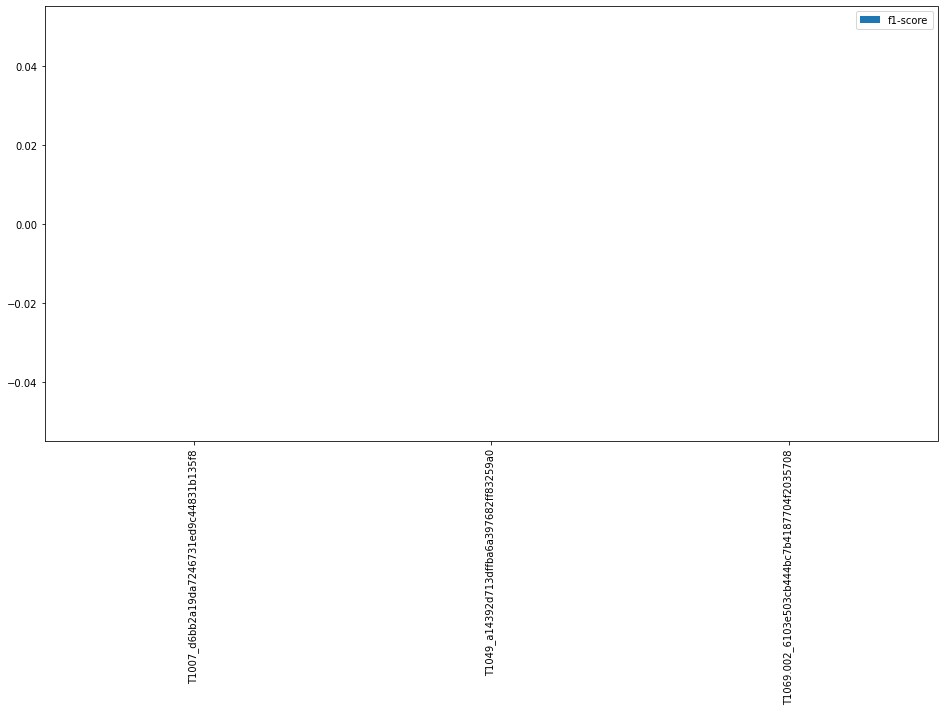

In [26]:
import matplotlib.pyplot as plt

# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()